
Rastrigin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=3109461b4ba28e9b03208a962912179d07141c9b69b126bf5a1befeedee06671
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
Beta_CBM = 1.5 # Default UCB Acquisition function parameter in pyGPGO https://github.com/josejimenezluna/pyGPGO/blob/master/pyGPGO/acquisition.py#L83
n_test = 500
eps = 1e-08

util_grad_exact = 'dCBM_GP'
util_grad_approx = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
        
def objfunc_der(x1_training, x2_training):
        return  operator * (2 * x1_training + 20 * np.pi * np.sin(2 * np.pi * x1_training)
                                    + 2 * x2_training + 20 * np.pi * np.sin(2 * np.pi * x2_training)
                          )
    
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM,
            'dCBM_GP': self.dCBM_GP
        }

        self.f = mode_dict[mode]

    def CBM(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (z + np.sqrt(Beta_CBM))

    def dCBM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1649238001.5160835

In [13]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.84969467  2.25612281]	 -20.33436270766351	 -19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 -33.07414982069084	 -19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 -53.347974723929894	 -19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 -39.218472310354045	 -19.908403246996286	    
init	 [-1.05710106  0.39748336]	 -19.908403246996286	 -19.908403246996286	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -19.908403246996286	 -2.4494900512168134
2  	 [4.59572391 5.12      ]	 -68.29054609461346	 -19.908403246996286	 -2.44948999466181
3  	 [-5.12  5.12]	 -57.849427451571785	 -19.908403246996286	 -2.4494729739933323
4  	 [ 4.14133522 -0.05944136]	 -21.534187073779243	 -19.908403246996286	 -2.4493812628684952
5  	 [ 0.90016241 -3.6892466 ]	 -30.049886475201713	 -19.908403246996286	 -2.446409838297879
6  	 [0.71631189 5.12      ]	 -41.538732225184575	 -19.908403246996286	 -2.3854508221

In [14]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.6554122  -4.85451539]	 -43.490296251903594	 -18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 -35.91861667536101	 -18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 -20.479562046739524	 -18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 -18.964539418712707	 -18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 -28.041315668371354	 -18.964539418712707	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -18.964539418712707	 -2.449488838640522
2  	 [5.12 5.12]	 -57.849427451571785	 -18.964539418712707	 -2.4494900511940085
3  	 [-0.09248709  5.12      ]	 -30.57474857107387	 -18.964539418712707	 -2.4493883916068424
4  	 [5.12       0.07743718]	 -30.091207554895554	 -18.964539418712707	 -2.4490475461012404
5  	 [-5.12  5.12]	 -57.849427451571785	 -18.964539418712707	 -2.4489129418449025
6  	 [-5.12 -5.12]	 -57.849427451571785	 -18.964539418712707	 -2.445774015575452
7  	 [2.3420631

In [15]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.52017052 2.1314337 ]	 -27.953858411008774	 -10.607662635789808	    
init	 [-2.14113547  0.11087468]	 -10.607662635789808	 -10.607662635789808	    
init	 [4.02377681 4.05804123]	 -33.42749829480097	 -10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 -28.650953928965198	 -10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 -57.6631355589384	 -10.607662635789808	    
1  	 [ 5.12       -3.42389633]	 -59.52614893420009	 -10.607662635789808	 -2.449490051139756
2  	 [-5.12  5.12]	 -57.849427451571785	 -10.607662635789808	 -2.4494879539152925
3  	 [ 0.45636433 -5.12      ]	 -48.75948187977113	 -10.607662635789808	 -2.4492109399261133
4  	 [5.12      0.4862525]	 -49.12387254887017	 -10.607662635789808	 -2.4196016673335365
5  	 [ 1.48047481 -1.42688943]	 -43.11599323396843	 -10.607662635789808	 -2.4053719054859046
6  	 [-1.23868611  5.12      ]	 -39.74878321505804	 -10.607662635789808	 -2.39982

In [16]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.78238555 0.48365823]	 -51.03163809010808	 -14.323038259018315	    
init	 [4.84028785 2.19971578]	 -39.78645699016559	 -14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 -14.323038259018315	 -14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 -52.80627247106233	 -14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 -41.61497868486559	 -14.323038259018315	    
1  	 [-5.12  5.12]	 -57.849427451571785	 -14.323038259018315	 -2.4494900125804304
2  	 [0.36023876 5.12      ]	 -45.440277277828315	 -14.323038259018315	 -2.449470702648422
3  	 [-5.12 -5.12]	 -57.849427451571785	 -14.323038259018315	 -2.449454032346059
4  	 [-0.95956808 -5.12      ]	 -30.1664377367294	 -14.323038259018315	 -2.436960247269063
5	 [0.85382962 1.14538762]	 -9.860329751054289	 -9.860329751054289	 -2.415987008527711
6  	 [-5.12        1.50099559]	 -51.17750582579479	 -9.860329751054289	 -2.3389421685692775
7  	 [3

In [17]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.84678993  3.79629882]	 -33.93442008827236	 -7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 -39.673876075575784	 -7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 -7.8108627039749745	 -7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 -25.38160395721669	 -7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 -22.589982116319675	 -7.8108627039749745	    
1  	 [ 5.12       -4.99290081]	 -53.8637188578435	 -7.8108627039749745	 -2.449488991838044
2  	 [5.12 5.12]	 -57.849427451571785	 -7.8108627039749745	 -2.4494862976392664
3  	 [-5.12       -0.04631954]	 -29.34738315471541	 -7.8108627039749745	 -2.44808818573155
4  	 [1.00367689 5.12      ]	 -29.93474956994232	 -7.8108627039749745	 -2.4365558660663273
5  	 [-5.12 -5.12]	 -57.849427451571785	 -7.8108627039749745	 -2.4318843627648055
6  	 [ 1.11157381 -5.12      ]	 -32.51858516907849	 -7.8108627039749745	 -2.429941399045183


In [18]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 4.02288795 -1.72052679]	 -31.08835710146886	 -17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 -58.797867722203385	 -17.28954482757088	    
init	 [-4.0175956   0.97333314]	 -17.28954482757088	 -17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 -19.296253155889353	 -17.28954482757088	    
init	 [-1.68542362  1.25459899]	 -28.650630936276173	 -17.28954482757088	    
1  	 [5.12 5.12]	 -57.849427451571785	 -17.28954482757088	 -2.4494900506317085
2  	 [-4.81397128 -4.71436888]	 -63.70763215223161	 -17.28954482757088	 -2.449489474704894
3  	 [-5.12  5.12]	 -57.849427451571785	 -17.28954482757088	 -2.448643693044207
4  	 [0.39539431 5.12      ]	 -46.99776126387555	 -17.28954482757088	 -2.4481568388621384
5  	 [-0.7527619 -5.12     ]	 -39.317837371138246	 -17.28954482757088	 -2.433665705020466
6  	 [2.84227944 1.91251932]	 -17.730606596758697	 -17.28954482757088	 -2.4103224301978137
7  	 [-2.

In [19]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.33860312  2.86636843]	 -45.646133072936244	 -22.52235437888213	    
init	 [-0.63068947  2.28828342]	 -34.83012662845338	 -22.52235437888213	    
init	 [4.8946126  0.39419771]	 -44.09657005662876	 -22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 -36.613209822404315	 -22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 -22.52235437888213	 -22.52235437888213	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -22.52235437888213	 -2.449462834923144
2  	 [ 5.12 -5.12]	 -57.849427451571785	 -22.52235437888213	 -2.4494546585718004
3  	 [3.59501824 5.12      ]	 -60.11903135913032	 -22.52235437888213	 -2.4493144137642164
4  	 [-4.02558214 -1.33646422]	 -33.289738493146906	 -22.52235437888213	 -2.4494900512168254
5	 [ 1.40596254 -0.96124855]	 -21.500334735340815	 -21.500334735340815	 -2.3932889081639472
6  	 [-1.80775721  5.12      ]	 -38.64283859090712	 -21.500334735340815	 -2.2190707699535

In [20]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.82391708 4.79785639]	 -50.20079446939181	 -13.871821018360485	    
init	 [3.78055209 0.31596228]	 -36.5114251593508	 -13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 -43.34985765011677	 -13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 -13.871821018360485	 -13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 -17.190590355445654	 -13.871821018360485	    
1  	 [-5.12  5.12]	 -57.849427451571785	 -13.871821018360485	 -2.449490051211691
2  	 [ 5.12 -5.12]	 -57.849427451571785	 -13.871821018360485	 -2.4494871997029084
3  	 [-5.12       -0.06205146]	 -29.67902052940042	 -13.871821018360485	 -2.449234635663399
4  	 [-0.66935056  4.17606515]	 -38.26063237466914	 -13.871821018360485	 -2.447391695791785
5  	 [ 1.18397129 -4.40964139]	 -45.24719436967881	 -13.871821018360485	 -2.4281227523355176
6  	 [-2.62583563  1.70380959]	 -39.693482266656645	 -13.871821018360485	 -2.13279811422841

In [21]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.01376866  0.01919582]	 -25.248289026162446	 -24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 -24.454800313488693	 -24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 -39.46509426509438	 -24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 -31.06766397812992	 -24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 -49.922543556206975	 -24.454800313488693	    
1  	 [3.58383911 5.12      ]	 -60.412937380611055	 -24.454800313488693	 -2.4494900512168254
2  	 [ 5.12       -0.51448477]	 -49.14802234086253	 -24.454800313488693	 -2.449488749456329
3  	 [-2.38963438  5.12      ]	 -52.32553514908594	 -24.454800313488693	 -2.449488767914829
4  	 [ 4.6971802 -5.12     ]	 -64.24639358917474	 -24.454800313488693	 -2.4488829016337
5  	 [0.65435751 1.54698846]	 -38.042864795141966	 -24.454800313488693	 -2.447316387036284
6  	 [-5.12       3.2212506]	 -47.50459899670015	 -24.454800313488693	

In [22]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.77832339 -4.90750004]	 -41.674330194390116	 -13.839458310244165	    
init	 [1.36855793 2.54775176]	 -44.69639719065837	 -13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 -13.839458310244165	 -13.839458310244165	    
init	 [-3.09183626  2.66783449]	 -33.23221510904937	 -13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 -54.73014366983691	 -13.839458310244165	    
1  	 [ 5.12       -0.56839694]	 -48.338485446448274	 -13.839458310244165	 -2.449226496008614
2  	 [5.12 5.12]	 -57.849427451571785	 -13.839458310244165	 -2.4487691474051565
3  	 [-5.12       -0.60617906]	 -47.148094957294475	 -13.839458310244165	 -2.4304331932016843
4  	 [-5.12  5.12]	 -57.849427451571785	 -13.839458310244165	 -2.344431158463675
5  	 [-0.8379314  5.12     ]	 -34.378765124855526	 -13.839458310244165	 -2.3103814121912167
6	 [-1.23134441 -0.10550153]	 -12.475659995438487	 -12.475659995438487	 -2.2702095765641

In [23]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.27403839 -4.92057353]	 -47.655641290890955	 -10.679755252484755	    
init	 [-0.37664229  2.30332343]	 -35.87889240695259	 -10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 -10.679755252484755	 -10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 -28.05462905574235	 -10.679755252484755	    
init	 [4.52410012 3.59214172]	 -71.62694632141611	 -10.679755252484755	    
1  	 [ 5.12       -4.33857962]	 -63.030690231802616	 -10.679755252484755	 -2.4494900511992403
2  	 [-5.12  5.12]	 -57.849427451571785	 -10.679755252484755	 -2.4494712150326596
3  	 [ 0.92374253 -5.12      ]	 -30.904095757722793	 -10.679755252484755	 -2.442516277930775
4  	 [ 3.11975237 -0.55671113]	 -32.1142995948097	 -10.679755252484755	 -2.4410429421342648
5  	 [1.20983666 5.12      ]	 -37.89158023754207	 -10.679755252484755	 -2.3076728624944525
6  	 [-1.93527609  5.12      ]	 -33.48558535159314	 -10.679755252484755	 -2.

In [24]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.54137249  2.45810889]	 -57.903242869085595	 -40.51116653209555	    
init	 [-2.42365424  0.34549139]	 -40.51116653209555	 -40.51116653209555	    
init	 [-4.97075238  4.28796936]	 -55.62655915398208	 -40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 -49.962803461970296	 -40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 -62.183891474990624	 -40.51116653209555	    
1  	 [5.12 5.12]	 -57.849427451571785	 -40.51116653209555	 -2.449490051216825
2  	 [-5.12 -5.12]	 -57.849427451571785	 -40.51116653209555	 -2.4494898837172765
3	 [2.51295487 0.83223602]	 -32.03427674075663	 -32.03427674075663	 -2.449220011735657
4  	 [0.33251366 5.12      ]	 -43.990611193811134	 -32.03427674075663	 -2.4485757302857105
5  	 [-0.48603629 -4.11887754]	 -39.82513640353719	 -32.03427674075663	 -2.4485299207104476
6  	 [-5.12       -1.54445981]	 -50.922420692482035	 -32.03427674075663	 -2.3123263090170068
7  	 [ 5

In [25]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.84367268 -2.68757791]	 -33.58019830007169	 -17.435826639425656	    
init	 [3.32061217 4.76927179]	 -56.857057997503354	 -17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 -48.211919361679726	 -17.435826639425656	    
init	 [1.11659482 2.82139151]	 -17.435826639425656	 -17.435826639425656	    
init	 [1.45012065 2.27346667]	 -38.25352329493884	 -17.435826639425656	    
1  	 [-5.12      -2.7263396]	 -47.838798104556766	 -17.435826639425656	 -2.4494900512165136
2  	 [-5.12  5.12]	 -57.849427451571785	 -17.435826639425656	 -2.4494900508369923
3  	 [-1.07703786 -5.12      ]	 -31.2335179062638	 -17.435826639425656	 -2.448708475120341
4	 [-2.85644989  1.12650973]	 -16.22385717899008	 -16.22385717899008	 -2.446627810565369
5  	 [-1.1550448  5.12     ]	 -34.640336780741485	 -16.22385717899008	 -2.420476713261133
6  	 [-0.62077913 -1.40888254]	 -38.03185440349279	 -16.22385717899008	 -2.387213220072

In [26]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.14277984 2.79721013]	 -18.683085263052178	 -10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 -47.36348784446708	 -10.423838604848608	    
init	 [-1.94830412  4.68586229]	 -40.19779334078636	 -10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 -10.423838604848608	 -10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 -30.353548735049138	 -10.423838604848608	    
1  	 [-5.12 -5.12]	 -57.84942745157173	 -10.423838604848608	 -2.4494897720008515
2  	 [5.12 5.12]	 -57.849427451571785	 -10.423838604848608	 -2.4494874768147765
3  	 [-5.12        0.35464195]	 -45.161763503151406	 -10.423838604848608	 -2.4494694883895622
4  	 [ 5.12       -0.06384334]	 -29.722623401519847	 -10.423838604848608	 -2.4494003325638354
5  	 [-5.12  5.12]	 -57.849427451571785	 -10.423838604848608	 -2.330103990245339
6  	 [-1.64800672  0.0436926 ]	 -19.07101600581196	 -10.423838604848608	 -2.3007168851603192
7  	

In [27]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.57189322 -3.28810573]	 -54.938487770767075	 -7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 -60.750198753157726	 -7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 -31.984997246800887	 -7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 -7.990765314336182	 -7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 -41.754957769694336	 -7.990765314336182	    
1  	 [4.71600276 5.12      ]	 -63.28529747371073	 -7.990765314336182	 -2.449490051216816
2  	 [-5.12  5.12]	 -57.849427451571785	 -7.990765314336182	 -2.4494872981616354
3  	 [-0.20716529  5.12      ]	 -36.30862131458308	 -7.990765314336182	 -2.4491350039330837
4  	 [2.26851359 1.12541793]	 -20.520865854642437	 -7.990765314336182	 -2.4476338211623383
5  	 [-0.33201688 -5.12      ]	 -43.963145259098255	 -7.990765314336182	 -2.441927609819419
6  	 [5.12      0.0460292]	 -29.342137609402968	 -7.990765314336182	 -2.319143626135

In [28]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.83349935  0.23719262]	 -22.27210456874814	 -22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 -57.57021076017139	 -22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 -33.89145899403749	 -22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 -35.85029586225333	 -22.27210456874814	    
init	 [-4.39987336  4.51595121]	 -77.78800881964571	 -22.27210456874814	    
1  	 [5.12 5.12]	 -57.849427451571785	 -22.27210456874814	 -2.4494900512168254
2  	 [5.12       0.13352717]	 -32.26029320716705	 -22.27210456874814	 -2.4492141322535903
3  	 [0.53982093 3.56715505]	 -51.82755583913017	 -22.27210456874814	 -2.448976110228115
4  	 [-5.12 -5.12]	 -57.849427451571785	 -22.27210456874814	 -2.448162901207399
5  	 [ 5.12 -5.12]	 -57.849427451571785	 -22.27210456874814	 -2.425220777409935
6	 [1.26304623 0.01625575]	 -12.466466547233672	 -12.466466547233672	 -2.362016252809615
7  	 [-5.12       -1.65401

In [29]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.10263037  0.31320838]	 -20.395145364684023	 -20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 -53.03732051200137	 -20.395145364684023	    
init	 [2.93873111 1.60085526]	 -29.989224812583537	 -20.395145364684023	    
init	 [1.40821398 0.77417363]	 -29.451989415882437	 -20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 -55.89242173757483	 -20.395145364684023	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -20.395145364684023	 -2.44949005063664
2  	 [-5.12        5.05158176]	 -54.963807772552855	 -20.395145364684023	 -2.449488617578953
3  	 [-0.25096492  5.12      ]	 -39.04832465800216	 -20.395145364684023	 -2.4488420110824194
4  	 [5.12 5.12]	 -57.849427451571785	 -20.395145364684023	 -2.446912988233613
5  	 [ 1.07732507 -3.5143834 ]	 -34.62791676441402	 -20.395145364684023	 -2.443701543173175
6  	 [ 5.12       -1.25380915]	 -40.73606452608816	 -20.395145364684023	 -2.4096437615021427

In [30]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53983224 0.05584255]	 -22.67190580753611	 -22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 -38.990099416711985	 -22.67190580753611	    
init	 [3.60686662 2.56139557]	 -56.66448698782129	 -22.67190580753611	    
init	 [1.70088108 4.99604939]	 -40.894059318256296	 -22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 -54.6725749848372	 -22.67190580753611	    
1  	 [-5.12        2.22636855]	 -42.4020726587362	 -22.67190580753611	 -2.4494900509193176
2  	 [-2.37391628  5.12      ]	 -51.5829480074582	 -22.67190580753611	 -2.4370622272852853
3  	 [-5.12       -1.79644078]	 -39.27518551518237	 -22.67190580753611	 -2.4343967654334304
4	 [-1.9078547   0.24187531]	 -14.817856959947829	 -14.817856959947829	 -2.38909743604242
5  	 [ 1.04802886 -5.12      ]	 -30.474971484328066	 -14.817856959947829	 -2.336085078509165
6  	 [5.12 5.12]	 -57.849427451571785	 -14.817856959947829	 -2.0508170985313736
7

In [31]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.12125592  2.6751971 ]	 -41.43485596167127	 -25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 -51.60126035043229	 -25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 -43.97430127029199	 -25.867003842388073	    
init	 [1.76104531 3.13952049]	 -25.867003842388073	 -25.867003842388073	    
init	 [4.9432772  1.38916592]	 -44.66580306903559	 -25.867003842388073	    
1  	 [ 5.12 -5.12]	 -57.849427451571785	 -25.867003842388073	 -2.4494900366289403
2  	 [ 1.77638486 -1.68662986]	 -28.227324808808422	 -25.867003842388073	 -2.446355882164541
3  	 [5.12 5.12]	 -57.849427451571785	 -25.867003842388073	 -2.4221723481964457
4  	 [-1.28670402  5.12      ]	 -42.866114606104645	 -25.867003842388073	 -2.413241292080429
5  	 [-5.12       -0.97841025]	 -29.97386718318932	 -25.867003842388073	 -2.412379625929092
6	 [-1.20044469  0.35640288]	 -24.702985938591134	 -24.702985938591134	 -2.400039288514409


In [32]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.9024594  4.07258857]	 -20.24255447774017	 -17.388691338534382	    
init	 [4.00927467 3.23417577]	 -35.55852254546393	 -17.388691338534382	    
init	 [-4.75249064  1.96359764]	 -36.54582989269194	 -17.388691338534382	    
init	 [-1.24230715  0.18955208]	 -17.388691338534382	 -17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 -33.22932870179905	 -17.388691338534382	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -17.388691338534382	 -2.449490047111669
2  	 [ 5.12      -0.9264602]	 -30.831700356502196	 -17.388691338534382	 -2.444678408277677
3  	 [ 5.12 -5.12]	 -57.849427451571785	 -17.388691338534382	 -2.442128519048078
4  	 [-2.70369427  5.12      ]	 -49.10327650362562	 -17.388691338534382	 -2.425367756112288
5  	 [-1.34011945 -5.12      ]	 -46.085237404752505	 -17.388691338534382	 -2.3974435467827493
6  	 [-5.12       -1.49922745]	 -51.172278865049485	 -17.388691338534382	 -2.364686086459179

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1649238087.2476625

In [34]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.84969467  2.25612281]	 -20.33436270766351	 -19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 -33.07414982069084	 -19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 -53.347974723929894	 -19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 -39.218472310354045	 -19.908403246996286	    
init	 [-1.05710106  0.39748336]	 -19.908403246996286	 -19.908403246996286	    
1  	 [ 4.04077223 -4.24914728]	 -44.655863836006326	 -19.908403246996286	 -2.4494897476658344
2  	 [5.12 5.12]	 -57.849427451571785	 -19.908403246996286	 -2.449489745255193
3  	 [4.33475417 0.43297623]	 -53.180980499532076	 -19.908403246996286	 -2.448750864179886
4  	 [-5.12        4.36680096]	 -64.69123843795754	 -19.908403246996286	 -2.4493778203046968
5  	 [ 0.15770233 -5.09604231]	 -32.281101249494625	 -19.908403246996286	 -2.4273022143109206
6  	 [1.14888935 5.12      ]	 -34.31049495059831	 -19.908403246996286	 -2.

In [35]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.6554122  -4.85451539]	 -43.490296251903594	 -18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 -35.91861667536101	 -18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 -20.479562046739524	 -18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 -18.964539418712707	 -18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 -28.041315668371354	 -18.964539418712707	    
1  	 [5.12       3.80451147]	 -50.04053833990521	 -18.964539418712707	 -2.449489728774618
2  	 [ 4.8426374  -3.96513962]	 -43.91494982239938	 -18.964539418712707	 -2.4494795787208776
3  	 [0.07189404 5.12      ]	 -29.932921716725147	 -18.964539418712707	 -2.449418798186937
4  	 [-5.12 -5.12]	 -57.849427451571785	 -18.964539418712707	 -2.445773712031007
5  	 [ 4.59822198 -0.06266717]	 -40.06813077177487	 -18.964539418712707	 -2.423267163050551
6  	 [-3.91741982  4.88362669]	 -43.06840046786972	 -18.964539418712707	 -2.4

In [36]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.52017052 2.1314337 ]	 -27.953858411008774	 -10.607662635789808	    
init	 [-2.14113547  0.11087468]	 -10.607662635789808	 -10.607662635789808	    
init	 [4.02377681 4.05804123]	 -33.42749829480097	 -10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 -28.650953928965198	 -10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 -57.6631355589384	 -10.607662635789808	    
1  	 [ 1.67759363 -3.17566699]	 -32.7907642079921	 -10.607662635789808	 -2.4494663387765687
2  	 [-3.5586837   4.82551617]	 -60.708950458775234	 -10.607662635789808	 -2.4493670308790456
3  	 [ 5.12       -0.35056886]	 -44.954343597875784	 -10.607662635789808	 -2.4481119780658616
4  	 [-1.57260703 -5.10194399]	 -49.46246710132813	 -10.607662635789808	 -2.320217691802906
5  	 [ 4.60147279 -3.45087817]	 -70.64501486031446	 -10.607662635789808	 -2.0690921628321632
6  	 [-5.12 -5.12]	 -57.849427451571785	 -10.607662635789808	 -1.

In [37]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.78238555 0.48365823]	 -51.03163809010808	 -14.323038259018315	    
init	 [4.84028785 2.19971578]	 -39.78645699016559	 -14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 -14.323038259018315	 -14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 -52.80627247106233	 -14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 -41.61497868486559	 -14.323038259018315	    
1  	 [-2.37593932  5.12      ]	 -51.68247856493545	 -14.323038259018315	 -2.4494886538051936
2  	 [-5.12 -5.12]	 -57.849427451571785	 -14.323038259018315	 -2.449453729222836
3  	 [1.96075057 5.12      ]	 -33.07180450648749	 -14.323038259018315	 -2.443520898139463
4  	 [0.79127676 1.31343866]	 -23.667976802215463	 -14.323038259018315	 -2.4221756700202883
5  	 [-1.110264   -4.91495882]	 -29.088855050017802	 -14.323038259018315	 -2.4324475861752144
6  	 [5.12 5.12]	 -57.849427451571785	 -14.323038259018315	 -2.1039140531714358
7

In [38]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.84678993  3.79629882]	 -33.93442008827236	 -7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 -39.673876075575784	 -7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 -7.8108627039749745	 -7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 -25.38160395721669	 -7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 -22.589982116319675	 -7.8108627039749745	    
1  	 [ 4.32894502 -5.09733749]	 -61.29459455724834	 -7.8108627039749745	 -2.449486758368113
2  	 [5.12 5.12]	 -57.849427451571785	 -7.8108627039749745	 -2.4494859945156664
3  	 [-5.12      -0.3119565]	 -42.81729278062776	 -7.8108627039749745	 -2.4475429256393397
4  	 [1.09394271 4.84389409]	 -30.788829932896668	 -7.8108627039749745	 -2.4335661573771743
5  	 [-5.12 -5.12]	 -57.849427451571785	 -7.8108627039749745	 -2.4317190462250307
6  	 [ 0.42044077 -5.0968539 ]	 -46.72629248166599	 -7.8108627039749745	 -2.35336416691327

In [39]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 4.02288795 -1.72052679]	 -31.08835710146886	 -17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 -58.797867722203385	 -17.28954482757088	    
init	 [-4.0175956   0.97333314]	 -17.28954482757088	 -17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 -19.296253155889353	 -17.28954482757088	    
init	 [-1.68542362  1.25459899]	 -28.650630936276173	 -17.28954482757088	    
1  	 [5.12 5.12]	 -57.849427451571785	 -17.28954482757088	 -2.449489747507372
2  	 [-5.12 -5.12]	 -57.849427451571785	 -17.28954482757088	 -2.449489708952214
3  	 [0.39229911 5.12      ]	 -46.87501812311753	 -17.28954482757088	 -2.44816377766472
4  	 [-0.9541143  -4.92165476]	 -26.73307634452152	 -17.28954482757088	 -2.4401386745757825
5  	 [3.88132972 1.66847902]	 -35.402978861430384	 -17.28954482757088	 -2.364972843209478
6  	 [-3.50139591  4.65918015]	 -69.36903863640266	 -17.28954482757088	 -2.4225002208876547
7  	 [-2.9

In [40]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.33860312  2.86636843]	 -45.646133072936244	 -22.52235437888213	    
init	 [-0.63068947  2.28828342]	 -34.83012662845338	 -22.52235437888213	    
init	 [4.8946126  0.39419771]	 -44.09657005662876	 -22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 -36.613209822404315	 -22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 -22.52235437888213	 -22.52235437888213	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -22.52235437888213	 -2.4494625317988077
2  	 [3.6046884 5.12     ]	 -59.83202676539142	 -22.52235437888213	 -2.449314092543103
3  	 [ 4.52828435 -4.16265102]	 -62.4586303924803	 -22.52235437888213	 -2.4481874593205983
4  	 [-4.02558214 -1.33646422]	 -33.289738493146906	 -22.52235437888213	 -2.449489748092488
5	 [ 1.30561198 -0.85934458]	 -19.52417325094436	 -19.52417325094436	 -2.389721413506355
6  	 [3.78708475e-03 5.12000000e+00]	 -28.927558933697078	 -19.52417325094436	 -2.146

In [41]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.82391708 4.79785639]	 -50.20079446939181	 -13.871821018360485	    
init	 [3.78055209 0.31596228]	 -36.5114251593508	 -13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 -43.34985765011677	 -13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 -13.871821018360485	 -13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 -17.190590355445654	 -13.871821018360485	    
1  	 [ 4.96376909 -4.82584897]	 -53.59844872912349	 -13.871821018360485	 -2.4494732919908127
2  	 [-5.03492225  2.95509263]	 -34.71822332027364	 -13.871821018360485	 -2.4494895208420493
3  	 [-0.88346773  5.12      ]	 -32.26813282256628	 -13.871821018360485	 -2.44881812936696
4  	 [ 1.08441138 -4.79070869]	 -32.97064673029292	 -13.871821018360485	 -2.4198030693054466
5  	 [-5.12       -1.44672638]	 -50.46272787164517	 -13.871821018360485	 -2.445861810921401
6	 [-1.95157666  1.92941829]	 -8.957947895158993	 -8.957947895158993	

In [42]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.01376866  0.01919582]	 -25.248289026162446	 -24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 -24.454800313488693	 -24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 -39.46509426509438	 -24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 -31.06766397812992	 -24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 -49.922543556206975	 -24.454800313488693	    
1  	 [5.12 5.12]	 -57.849427451571785	 -24.454800313488693	 -2.449489748092488
2  	 [ 5.03440896 -1.04940511]	 -27.157274210864554	 -24.454800313488693	 -2.449488812746501
3  	 [-1.47691506  4.45110811]	 -61.42048237139477	 -24.454800313488693	 -2.449488650847006
4  	 [1.55214118 1.27521028]	 -35.08082861460935	 -24.454800313488693	 -2.44484592885011
5  	 [-2.25497862  1.29081783]	 -29.600541604094882	 -24.454800313488693	 -2.130947101748851
6  	 [1.83249056 5.12      ]	 -37.328663947571414	 -24.454800313488693	 -2.2062

In [43]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.77832339 -4.90750004]	 -41.674330194390116	 -13.839458310244165	    
init	 [1.36855793 2.54775176]	 -44.69639719065837	 -13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 -13.839458310244165	 -13.839458310244165	    
init	 [-3.09183626  2.66783449]	 -33.23221510904937	 -13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 -54.73014366983691	 -13.839458310244165	    
1  	 [ 5.12      -0.5383034]	 -48.926275596809745	 -13.839458310244165	 -2.449224747404672
2  	 [5.12 5.12]	 -57.849427451571785	 -13.839458310244165	 -2.44876838836928
3  	 [-4.22754268 -0.73799151]	 -37.76419130208299	 -13.839458310244165	 -2.377440773372147
4  	 [ 1.6857887  -0.65019156]	 -33.05869431933419	 -13.839458310244165	 -2.0989729415242535
5  	 [-4.5050859   5.00650982]	 -65.36419794062027	 -13.839458310244165	 -2.052345227016331
6  	 [0.10579747 5.07144996]	 -28.85095188801787	 -13.839458310244165	 -2.02712043

In [44]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.27403839 -4.92057353]	 -47.655641290890955	 -10.679755252484755	    
init	 [-0.37664229  2.30332343]	 -35.87889240695259	 -10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 -10.679755252484755	 -10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 -28.05462905574235	 -10.679755252484755	    
init	 [4.52410012 3.59214172]	 -71.62694632141611	 -10.679755252484755	    
1  	 [ 3.03550212 -4.46785095]	 -49.22040431745476	 -10.679755252484755	 -2.449489435906896
2  	 [ 4.25323565 -0.5528833 ]	 -48.05200627346154	 -10.679755252484755	 -2.437548387085586
3  	 [-1.00998464  5.12      ]	 -29.9644548738855	 -10.679755252484755	 -2.1731977411938357
4  	 [-0.1498654  -3.28114116]	 -26.84785009433122	 -10.679755252484755	 -2.2967053037974803
5  	 [-3.75487238  2.90204475]	 -34.04982141734267	 -10.679755252484755	 -2.304102951511026
6  	 [-2.84197049 -1.78968062]	 -23.349905392528232	 -10.6797552524

In [45]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.54137249  2.45810889]	 -57.903242869085595	 -40.51116653209555	    
init	 [-2.42365424  0.34549139]	 -40.51116653209555	 -40.51116653209555	    
init	 [-4.97075238  4.28796936]	 -55.62655915398208	 -40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 -49.962803461970296	 -40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 -62.183891474990624	 -40.51116653209555	    
1  	 [5.12 5.12]	 -57.849427451571785	 -40.51116653209555	 -2.4494897480924878
2  	 [-5.12 -5.12]	 -57.849427451571785	 -40.51116653209555	 -2.4494895805929398
3	 [2.3912107  0.97308311]	 -24.56085142111143	 -24.56085142111143	 -2.4491798164653296
4  	 [-0.46882319 -4.42580331]	 -58.549145121093275	 -24.56085142111143	 -2.4484602828832895
5  	 [0.89212895 4.54028969]	 -43.30170734350933	 -24.56085142111143	 -2.4392077931320775
6  	 [-5.12       -1.70147252]	 -44.82176875961964	 -24.56085142111143	 -2.3010206818615875
7  	 [5

In [46]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.84367268 -2.68757791]	 -33.58019830007169	 -17.435826639425656	    
init	 [3.32061217 4.76927179]	 -56.857057997503354	 -17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 -48.211919361679726	 -17.435826639425656	    
init	 [1.11659482 2.82139151]	 -17.435826639425656	 -17.435826639425656	    
init	 [1.45012065 2.27346667]	 -38.25352329493884	 -17.435826639425656	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -17.435826639425656	 -2.4494897480924736
2  	 [-4.47999344  1.98768889]	 -43.97224621034277	 -17.435826639425656	 -2.449489228862192
3  	 [-2.01225182 -1.58963993]	 -25.061108045106813	 -17.435826639425656	 -2.4471976183555015
4  	 [-1.67908196  5.12      ]	 -46.05394415768511	 -17.435826639425656	 -2.442389278899868
5  	 [-0.44763868 -5.12      ]	 -48.588766654898436	 -17.435826639425656	 -2.4378809652118916
6  	 [-5.06500451 -1.83011041]	 -35.002526374257776	 -17.435826639425656	 -2.

In [47]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.14277984 2.79721013]	 -18.683085263052178	 -10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 -47.36348784446708	 -10.423838604848608	    
init	 [-1.94830412  4.68586229]	 -40.19779334078636	 -10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 -10.423838604848608	 -10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 -30.353548735049138	 -10.423838604848608	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -10.423838604848608	 -2.449489468876515
2  	 [5.12 5.12]	 -57.849427451571785	 -10.423838604848608	 -2.4494871736904393
3  	 [-4.95963276  0.2443801 ]	 -34.62457561811984	 -10.423838604848608	 -2.4494614027041384
4  	 [4.80685716 0.029873  ]	 -29.78546726011794	 -10.423838604848608	 -2.449366556437026
5  	 [-1.55693718  0.01376852]	 -21.828521431680493	 -10.423838604848608	 -2.282645177873138
6  	 [-1.71669875 -5.12      ]	 -43.94891311635857	 -10.423838604848608	 -2.23841011534487

In [48]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.57189322 -3.28810573]	 -54.938487770767075	 -7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 -60.750198753157726	 -7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 -31.984997246800887	 -7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 -7.990765314336182	 -7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 -41.754957769694336	 -7.990765314336182	    
1  	 [5.12 5.12]	 -57.849427451571785	 -7.990765314336182	 -2.449489748092484
2  	 [-0.3517064  5.12     ]	 -45.0126640376181	 -7.990765314336182	 -2.4494587152065357
3  	 [2.59308727 1.16950193]	 -31.58465744363692	 -7.990765314336182	 -2.447991430601713
4  	 [-5.09479233  4.00341422]	 -43.708402484060926	 -7.990765314336182	 -2.4489826100369303
5  	 [-1.61688397 -5.12      ]	 -48.96133288911461	 -7.990765314336182	 -2.3985521070100964
6  	 [ 0.44189922 -1.25734852]	 -31.578788152019204	 -7.990765314336182	 -2.148010801581

In [49]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.83349935  0.23719262]	 -22.27210456874814	 -22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 -57.57021076017139	 -22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 -33.89145899403749	 -22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 -35.85029586225333	 -22.27210456874814	    
init	 [-4.39987336  4.51595121]	 -77.78800881964571	 -22.27210456874814	    
1  	 [5.12 5.12]	 -57.849427451571785	 -22.27210456874814	 -2.449489748092488
2  	 [5.12       0.13571646]	 -32.36384852723622	 -22.27210456874814	 -2.4492138166203437
3  	 [0.43755246 3.98750252]	 -35.36249906528404	 -22.27210456874814	 -2.44889848344717
4  	 [-5.12 -5.12]	 -57.849427451571785	 -22.27210456874814	 -2.4481625980949278
5  	 [0.83155422 0.43908501]	 -25.257844782959424	 -22.27210456874814	 -2.393941908958801
6  	 [ 5.12       -3.28383331]	 -51.81810925355856	 -22.27210456874814	 -2.3073043915029503
7  	 [3.324698

In [50]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.10263037  0.31320838]	 -20.395145364684023	 -20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 -53.03732051200137	 -20.395145364684023	    
init	 [2.93873111 1.60085526]	 -29.989224812583537	 -20.395145364684023	    
init	 [1.40821398 0.77417363]	 -29.451989415882437	 -20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 -55.89242173757483	 -20.395145364684023	    
1  	 [ 4.96008736 -4.44720822]	 -64.14783177084814	 -20.395145364684023	 -2.449489699115889
2  	 [-1.516385  5.12    ]	 -51.17119047788117	 -20.395145364684023	 -2.4493921735536537
3  	 [5.12 5.12]	 -57.849427451571785	 -20.395145364684023	 -2.4469232867713924
4  	 [ 0.77482007 -3.17286579]	 -24.45527185571842	 -20.395145364684023	 -2.4371084967022436
5  	 [ 5.12       -0.62326114]	 -46.4610677499605	 -20.395145364684023	 -2.317486589787148
6  	 [-4.62701383  2.47156644]	 -64.33976860834052	 -20.395145364684023	 -2.39040362

In [51]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53983224 0.05584255]	 -22.67190580753611	 -22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 -38.990099416711985	 -22.67190580753611	    
init	 [3.60686662 2.56139557]	 -56.66448698782129	 -22.67190580753611	    
init	 [1.70088108 4.99604939]	 -40.894059318256296	 -22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 -54.6725749848372	 -22.67190580753611	    
1  	 [-5.00718904  2.9174042 ]	 -34.91005808676357	 -22.67190580753611	 -2.449489747603107
2  	 [-2.51728811 -0.57162977]	 -45.608758197849326	 -22.67190580753611	 -2.4420850988272913
3	 [-1.16209189  2.8435501 ]	 -18.644148049560222	 -18.644148049560222	 -2.3724741943337717
4  	 [ 0.94304294 -5.09915178]	 -29.402853384030077	 -18.644148049560222	 -2.3280086932419537
5  	 [-5.12       -3.24646935]	 -49.24245781171351	 -18.644148049560222	 -2.1834370156216645
6  	 [5.12 5.12]	 -57.849427451571785	 -18.644148049560222	 -2.050830035002

In [52]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.12125592  2.6751971 ]	 -41.43485596167127	 -25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 -51.60126035043229	 -25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 -43.97430127029199	 -25.867003842388073	    
init	 [1.76104531 3.13952049]	 -25.867003842388073	 -25.867003842388073	    
init	 [4.9432772  1.38916592]	 -44.66580306903559	 -25.867003842388073	    
1  	 [ 4.23957591 -4.3180944 ]	 -60.11460004389352	 -25.867003842388073	 -2.449487979038283
2	 [-0.8522331  0.1097962]	 -7.034284559434696	 -7.034284559434696	 -2.43752941549335
3  	 [5.12 5.12]	 -57.849427451571785	 -7.034284559434696	 -2.422171921281958
4  	 [-5.11258145 -1.10557084]	 -31.880524619679164	 -7.034284559434696	 -2.408944585107038
5  	 [ 2.12840218 -1.35523672]	 -25.58926950497882	 -7.034284559434696	 -2.384709827892259
6  	 [-1.01625331  4.44665747]	 -40.30120687312824	 -7.034284559434696	 -2.298265373385901
7

In [53]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.9024594  4.07258857]	 -20.24255447774017	 -17.388691338534382	    
init	 [4.00927467 3.23417577]	 -35.55852254546393	 -17.388691338534382	    
init	 [-4.75249064  1.96359764]	 -36.54582989269194	 -17.388691338534382	    
init	 [-1.24230715  0.18955208]	 -17.388691338534382	 -17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 -33.22932870179905	 -17.388691338534382	    
1  	 [-5.12 -5.12]	 -57.849427451571785	 -17.388691338534382	 -2.4494897439873324
2  	 [ 5.12       -0.90740925]	 -31.3931634996558	 -17.388691338534382	 -2.4446708533078523
3  	 [-2.3233602   4.69581862]	 -55.23551883301417	 -17.388691338534382	 -2.380799750743602
4  	 [-1.42211964 -5.12      ]	 -49.77358600104105	 -17.388691338534382	 -2.395605300698754
5  	 [-4.99247735 -1.5188041 ]	 -47.173048884724054	 -17.388691338534382	 -2.3625876755303006
6  	 [ 4.69080964 -4.43534108]	 -74.49588153721578	 -17.388691338534382	 -2.357

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

473.3104135990143

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.534734985366455, 3.2468015438365843)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(3.1097541277959015, 2.6460846520456456)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(2.630753620765267, 3.0286830385185066)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(2.288519611367123, 2.4551997431578734)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.8616723236258255, 2.8525855540382645)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.301984920639246, 1.8073466498133655)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.6362433768276645, 2.6245049423824436)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6994698284331173, 2.1925411711974165)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.8211368256926237, 3.061260721864964)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.5237795456841097, 2.2897144496777004)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.5708806177706016, 2.6610655591361283)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(2.167662637440424, 2.881452365869826)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.7635324288133383, 2.2313760555386803)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(2.451190767739531, 2.8212900849919444)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.8195638943055337, 3.046565491183561)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.8622890658227697, 2.1144410502644675)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.4279682679331938, 2.585600314061042)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.372147072389316, 2.484600693728315)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.981598638394232, 1.9507959880863297)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.6569340870995983, 2.443007859521501)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

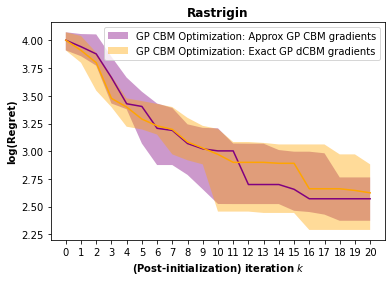

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM Optimization: Approx GP CBM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP CBM Optimization: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(85.73149418830872, 473.3104135990143)

In [100]:
exact21_results, exact21_results[19:20].index[0]


(           0
 0   3.246802
 8   3.061261
 14  3.046565
 2   3.028683
 11  2.881452
 4   2.852586
 13  2.821290
 10  2.661066
 1   2.646085
 6   2.624505
 16  2.585600
 17  2.484601
 3   2.455200
 19  2.443008
 9   2.289714
 12  2.231376
 7   2.192541
 15  2.114441
 18  1.950796
 5   1.807347, 5)

In [101]:
str_exact = str(exact21_results[19:20].index[0]+1)
str_exact


'6'

In [102]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-9.994000077126026, -0.7062141396581355, 2.301984920639246)

In [103]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 4.02288795 -1.72052679]	 -31.08835710146886	 -17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 -58.797867722203385	 -17.28954482757088	    
init	 [-4.0175956   0.97333314]	 -17.28954482757088	 -17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 -19.296253155889353	 -17.28954482757088	    
init	 [-1.68542362  1.25459899]	 -28.650630936276173	 -17.28954482757088	    
1  	 [5.12 5.12]	 -57.849427451571785	 -17.28954482757088	 -2.4494900506317085
2  	 [-4.81397128 -4.71436888]	 -63.70763215223161	 -17.28954482757088	 -2.449489474704894
3  	 [-5.12  5.12]	 -57.849427451571785	 -17.28954482757088	 -2.448643693044207
4  	 [0.39539431 5.12      ]	 -46.99776126387555	 -17.28954482757088	 -2.4481568388621384
5  	 [-0.7527619 -5.12     ]	 -39.317837371138246	 -17.28954482757088	 -2.433665705020466
6  	 [2.84227944 1.91251932]	 -17.730606596758697	 -17.28954482757088	 -2.4103224301978137
7  	 [-2.

In [104]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[ 5.12      , -0.67302167],
        [-2.64297161, -0.30172283],
        [ 5.12      ,  2.91440431],
        [-2.64297149, -0.30172268],
        [ 5.12      , -0.67302169],
        [ 3.5529612 ,  0.19343112],
        [-0.75041846,  3.07754816],
        [ 5.12      ,  2.9144043 ],
        [-2.60240327, -4.28254759],
        [-2.60240288, -4.28254862],
        [-2.64297122, -0.30172318],
        [-2.60240288, -4.28254848],
        [ 5.12      ,  2.91440431],
        [-2.64297132, -0.30172288],
        [-2.64297121, -0.30172281],
        [-2.60240286, -4.28254835],
        [-2.95383299,  2.12924561],
        [-1.63199567,  5.12      ],
        [-2.64297152, -0.30172281],
        [-2.95383304,  2.12924556]]),
 array([5.63, 4.41, 4.13, 4.41, 5.63, 7.39, 7.55, 4.13, 3.92, 3.92, 4.41,
        3.92, 4.13, 4.41, 4.41, 3.92, 8.22, 8.6 , 4.41, 8.22]),
 array([-2.60240286, -4.28254835]),
 array([-2.60240286, -4.28254835]))

In [105]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_minAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_simpleRegret


(-6.09425576597569, 0.43860040469487427, 1.8073466498133655)

In [106]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 4.02288795 -1.72052679]	 -31.08835710146886	 -17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 -58.797867722203385	 -17.28954482757088	    
init	 [-4.0175956   0.97333314]	 -17.28954482757088	 -17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 -19.296253155889353	 -17.28954482757088	    
init	 [-1.68542362  1.25459899]	 -28.650630936276173	 -17.28954482757088	    
1  	 [5.12 5.12]	 -57.849427451571785	 -17.28954482757088	 -2.449489747507372
2  	 [-5.12 -5.12]	 -57.849427451571785	 -17.28954482757088	 -2.449489708952214
3  	 [0.39229911 5.12      ]	 -46.87501812311753	 -17.28954482757088	 -2.44816377766472
4  	 [-0.9541143  -4.92165476]	 -26.73307634452152	 -17.28954482757088	 -2.4401386745757825
5  	 [3.88132972 1.66847902]	 -35.402978861430384	 -17.28954482757088	 -2.364972843209478
6  	 [-3.50139591  4.65918015]	 -69.36903863640266	 -17.28954482757088	 -2.4225002208876547
7  	 [-2.9

In [107]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned


(array([[ 4.9340119 , -3.15179319],
        [-2.70186969, -0.90331021],
        [ 2.66343726,  5.12      ],
        [-1.42250807,  5.12      ],
        [ 1.83984817,  0.30652122],
        [-1.88319753, -2.67095951],
        [-2.37728054,  2.75206257],
        [ 4.34181992,  3.60727995],
        [-2.62884858, -0.94365962],
        [-4.90705936, -0.18429704],
        [-2.51769924, -1.0096488 ],
        [-1.04218704, -3.47826009],
        [-2.39895786,  2.76665415],
        [ 1.01109396,  2.60072218],
        [ 1.82641165,  0.33737376],
        [ 1.19701725,  2.10364571],
        [-2.8819426 ,  2.94051291],
        [ 3.54483819,  4.87153079],
        [ 1.58280257,  1.28062998],
        [ 0.48298345,  3.42814719]]),
 array([ 3.39,  7.22,  6.87,  6.14,  4.18,  6.16,  6.81, 13.26,  7.6 ,
         2.38,  8.16,  7.71,  6.82,  7.33,  4.26,  6.22,  9.09, 12.87,
         5.77, 12.18]),
 array([-4.90705936, -0.18429704]),
 array([-4.90705936, -0.18429704]))

In [108]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: y-value is greater

True

In [109]:
eval_exactMinIQR_minAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc # Exact gradients' model: best AcqFunc is greater


True

In [110]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log is lower


True

In [111]:
eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_minAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc


(0.43860040469487427, -0.7062141396581355, -0.6210586563831647)

In [112]:
### MinAcqFunc Comparison: Approximate Gradients

approx_1minAcqFunc = approx_1.history[:-1][1::2]
approx_2minAcqFunc = approx_2.history[:-1][1::2]
approx_3minAcqFunc = approx_3.history[:-1][1::2]
approx_4minAcqFunc = approx_4.history[:-1][1::2]
approx_5minAcqFunc = approx_5.history[:-1][1::2]
approx_6minAcqFunc = approx_6.history[:-1][1::2]
approx_7minAcqFunc = approx_7.history[:-1][1::2]
approx_8minAcqFunc = approx_8.history[:-1][1::2]
approx_9minAcqFunc = approx_9.history[:-1][1::2]
approx_10minAcqFunc = approx_10.history[:-1][1::2]
approx_11minAcqFunc = approx_11.history[:-1][1::2]
approx_12minAcqFunc = approx_12.history[:-1][1::2]
approx_13minAcqFunc = approx_13.history[:-1][1::2]
approx_14minAcqFunc = approx_14.history[:-1][1::2]
approx_15minAcqFunc = approx_15.history[:-1][1::2]
approx_16minAcqFunc = approx_16.history[:-1][1::2]
approx_17minAcqFunc = approx_17.history[:-1][1::2]
approx_18minAcqFunc = approx_18.history[:-1][1::2]
approx_19minAcqFunc = approx_19.history[:-1][1::2]
approx_20minAcqFunc = approx_20.history[:-1][1::2]


In [113]:
### MinAcqFunc Comparison: Exact Gradients

exact_1minAcqFunc = exact_1.history[:-1][1::2]
exact_2minAcqFunc = exact_2.history[:-1][1::2]
exact_3minAcqFunc = exact_3.history[:-1][1::2]
exact_4minAcqFunc = exact_4.history[:-1][1::2]
exact_5minAcqFunc = exact_5.history[:-1][1::2]
exact_6minAcqFunc = exact_6.history[:-1][1::2]
exact_7minAcqFunc = exact_7.history[:-1][1::2]
exact_8minAcqFunc = exact_8.history[:-1][1::2]
exact_9minAcqFunc = exact_9.history[:-1][1::2]
exact_10minAcqFunc = exact_10.history[:-1][1::2]
exact_11minAcqFunc = exact_11.history[:-1][1::2]
exact_12minAcqFunc = exact_12.history[:-1][1::2]
exact_13minAcqFunc = exact_13.history[:-1][1::2]
exact_14minAcqFunc = exact_14.history[:-1][1::2]
exact_15minAcqFunc = exact_15.history[:-1][1::2]
exact_16minAcqFunc = exact_16.history[:-1][1::2]
exact_17minAcqFunc = exact_17.history[:-1][1::2]
exact_18minAcqFunc = exact_18.history[:-1][1::2]
exact_19minAcqFunc = exact_19.history[:-1][1::2]
exact_20minAcqFunc = exact_20.history[:-1][1::2]


In [114]:
### MinAcqFunc Comparison: Experiment 1

minAcqFuncApprox1 = np.mean(approx_1minAcqFunc)
minAcqFuncExact1 = np.mean(exact_1minAcqFunc)
ratio1 = minAcqFuncApprox1/minAcqFuncExact1
approx_1.tau, exact_1.tau, minAcqFuncApprox1, minAcqFuncExact1, ratio1


(-12.61308775224328,
 -19.908403246996286,
 -0.600855803285608,
 0.1535587661009806,
 -3.912872045940274)

In [115]:
### MinAcqFunc Comparison: Experiment 2

minAcqFuncApprox2 = np.mean(approx_2minAcqFunc)
minAcqFuncExact2 = np.mean(exact_2minAcqFunc)
ratio2 = minAcqFuncApprox2/minAcqFuncExact2
approx_2.tau, exact_2.tau, minAcqFuncApprox2, minAcqFuncExact2, ratio2


(-18.964539418712707,
 -14.098729008015335,
 -0.8842678598851181,
 0.027253056526633523,
 -32.446557288755926)

In [116]:
### MinAcqFunc Comparison: Experiment 3

minAcqFuncApprox3 = np.mean(approx_3minAcqFunc)
minAcqFuncExact3 = np.mean(exact_3minAcqFunc)
ratio3 = minAcqFuncApprox3/minAcqFuncExact3
approx_3.tau, exact_3.tau, minAcqFuncApprox3, minAcqFuncExact3, ratio3


(-10.607662635789808,
 -10.607662635789808,
 -0.05893311372409098,
 0.10908417666968266,
 -0.5402535502701377)

In [117]:
### MinAcqFunc Comparison: Experiment 4

minAcqFuncApprox4 = np.mean(approx_4minAcqFunc)
minAcqFuncExact4 = np.mean(exact_4minAcqFunc)
ratio4 = minAcqFuncApprox4/minAcqFuncExact4
approx_4.tau, exact_4.tau, minAcqFuncApprox4, minAcqFuncExact4, ratio4


(-9.860329751054289,
 -11.648760076640748,
 -0.7330331981328518,
 -0.5910792335805163,
 1.2401606358126245)

In [118]:
### MinAcqFunc Comparison: Experiment 5

minAcqFuncApprox5 = np.mean(approx_5minAcqFunc)
minAcqFuncExact5 = np.mean(exact_5minAcqFunc)
ratio5 = minAcqFuncApprox5/minAcqFuncExact5
approx_5.tau, exact_5.tau, minAcqFuncApprox5, minAcqFuncExact5, ratio5


(-6.434488325731507,
 -7.8108627039749745,
 -1.1594870965570356,
 -0.6779053333527515,
 1.7103967759369885)

In [119]:
### MinAcqFunc Comparison: Experiment 6

minAcqFuncApprox6 = np.mean(approx_6minAcqFunc)
minAcqFuncExact6 = np.mean(exact_6minAcqFunc)
ratio6 = minAcqFuncApprox6/minAcqFuncExact6
approx_6.tau, exact_6.tau, minAcqFuncApprox6, minAcqFuncExact6, ratio6


(-9.994000077126026,
 -6.09425576597569,
 -7.207699459789312,
 -5.534625677079452,
 1.3022921296445686)

In [120]:
### MinAcqFunc Comparison: Experiment 7

minAcqFuncApprox7 = np.mean(approx_7minAcqFunc)
minAcqFuncExact7 = np.mean(exact_7minAcqFunc)
ratio7 = minAcqFuncApprox7/minAcqFuncExact7
approx_7.tau, exact_7.tau, minAcqFuncApprox7, minAcqFuncExact7, ratio7


(-13.960660037331387,
 -13.797741817806676,
 -0.020924802472307748,
 0.5282180211293305,
 -0.03961395036763514)

In [121]:
### MinAcqFunc Comparison: Experiment 8

minAcqFuncApprox8 = np.mean(approx_8minAcqFunc)
minAcqFuncExact8 = np.mean(exact_8minAcqFunc)
ratio8 = minAcqFuncApprox8/minAcqFuncExact8
approx_8.tau, exact_8.tau, minAcqFuncApprox8, minAcqFuncExact8, ratio8


(-13.871821018360485,
 -8.957947895158993,
 -0.4933189410720136,
 -0.321882676220394,
 1.5326048200687776)

In [122]:
### MinAcqFunc Comparison: Experiment 9

minAcqFuncApprox9 = np.mean(approx_9minAcqFunc)
minAcqFuncExact9 = np.mean(exact_9minAcqFunc)
ratio9 = minAcqFuncApprox9/minAcqFuncExact9
approx_9.tau, exact_9.tau, minAcqFuncApprox9, minAcqFuncExact9, ratio9


(-16.795933872106065,
 -21.354462236011248,
 -0.5251461155627128,
 -0.05323262749035669,
 9.865117322225833)

In [123]:
### MinAcqFunc Comparison: Experiment 10

minAcqFuncApprox10 = np.mean(approx_10minAcqFunc)
minAcqFuncExact10 = np.mean(exact_10minAcqFunc)
ratio10 = minAcqFuncApprox10/minAcqFuncExact10
approx_10.tau, exact_10.tau, minAcqFuncApprox10, minAcqFuncExact10, ratio10


(-12.475659995438487,
 -9.872118292093525,
 -0.5070910150903876,
 -0.138939496475452,
 3.649725441318128)

In [124]:
### MinAcqFunc Comparison: Experiment 11

minAcqFuncApprox11 = np.mean(approx_11minAcqFunc)
minAcqFuncExact11 = np.mean(exact_11minAcqFunc)
ratio11 = minAcqFuncApprox11/minAcqFuncExact11
approx_11.tau, exact_11.tau, minAcqFuncApprox11, minAcqFuncExact11, ratio11


(-10.679755252484755,
 -10.679755252484755,
 -0.27542175842882116,
 0.29418821710740894,
 -0.9362093463052054)

In [125]:
### MinAcqFunc Comparison: Experiment 12

minAcqFuncApprox12 = np.mean(approx_12minAcqFunc)
minAcqFuncExact12 = np.mean(exact_12minAcqFunc)
ratio12 = minAcqFuncApprox12/minAcqFuncExact12
approx_12.tau, exact_12.tau, minAcqFuncApprox12, minAcqFuncExact12, ratio12


(-8.737836661316548,
 -17.84016481948981,
 -0.659607630241973,
 0.13097410012163663,
 -5.03616844574149)

In [126]:
### MinAcqFunc Comparison: Experiment 13

minAcqFuncApprox13 = np.mean(approx_13minAcqFunc)
minAcqFuncExact13 = np.mean(exact_13minAcqFunc)
ratio13 = minAcqFuncApprox13/minAcqFuncExact13
approx_13.tau, exact_13.tau, minAcqFuncApprox13, minAcqFuncExact13, ratio13


(-15.855753460551497,
 -9.312672020533597,
 -0.6271723579401133,
 -0.2845844542072416,
 2.203818053544803)

In [127]:
### MinAcqFunc Comparison: Experiment 14

minAcqFuncApprox14 = np.mean(approx_14minAcqFunc)
minAcqFuncExact14 = np.mean(exact_14minAcqFunc)
ratio14 = minAcqFuncApprox14/minAcqFuncExact14
approx_14.tau, exact_14.tau, minAcqFuncApprox14, minAcqFuncExact14, ratio14


(-10.423838604848608,
 -10.423838604848608,
 -0.6084069202004951,
 0.005799637322855577,
 -104.90430458519306)

In [128]:
### MinAcqFunc Comparison: Experiment 15

minAcqFuncApprox15 = np.mean(approx_15minAcqFunc)
minAcqFuncExact15 = np.mean(exact_15minAcqFunc)
ratio15 = minAcqFuncApprox15/minAcqFuncExact15
approx_15.tau, exact_15.tau, minAcqFuncApprox15, minAcqFuncExact15, ratio15


(-7.990765314336182,
 -7.990765314336182,
 -0.729423747973428,
 0.1467612459987951,
 -4.97013869710139)

In [129]:
### MinAcqFunc Comparison: Experiment 16

minAcqFuncApprox16 = np.mean(approx_16minAcqFunc)
minAcqFuncExact16 = np.mean(exact_16minAcqFunc)
ratio16 = minAcqFuncApprox16/minAcqFuncExact16
approx_16.tau, exact_16.tau, minAcqFuncApprox16, minAcqFuncExact16, ratio16


(-2.368576320081349,
 -8.28495359904246,
 -0.9603027497517749,
 0.26613222068458253,
 -3.6083671014413428)

In [130]:
### MinAcqFunc Comparison: Experiment 17

minAcqFuncApprox17 = np.mean(approx_17minAcqFunc)
minAcqFuncExact17 = np.mean(exact_17minAcqFunc)
ratio17 = minAcqFuncApprox17/minAcqFuncExact17
approx_17.tau, exact_17.tau, minAcqFuncApprox17, minAcqFuncExact17, ratio17


(-11.335827303531488,
 -13.271253619274697,
 -0.49168096206092765,
 0.3214769275898173,
 -1.5294440125055542)

In [131]:
### MinAcqFunc Comparison: Experiment 18

minAcqFuncApprox18 = np.mean(approx_18minAcqFunc)
minAcqFuncExact18 = np.mean(exact_18minAcqFunc)
ratio18 = minAcqFuncApprox18/minAcqFuncExact18
approx_18.tau, exact_18.tau, minAcqFuncApprox18, minAcqFuncExact18, ratio18


(-10.720385034438747,
 -11.996329088881167,
 -0.19900888518584509,
 0.2766968849885886,
 -0.7192306671397928)

In [132]:
### MinAcqFunc Comparison: Experiment 19

minAcqFuncApprox19 = np.mean(approx_19minAcqFunc)
minAcqFuncExact19 = np.mean(exact_19minAcqFunc)
ratio19 = minAcqFuncApprox19/minAcqFuncExact19
approx_19.tau, exact_19.tau, minAcqFuncApprox19, minAcqFuncExact19, ratio19


(-19.719315515292898,
 -7.034284559434696,
 -0.4218090729263584,
 -0.024015831231661844,
 17.563792352531873)

In [133]:
### MinAcqFunc Comparison: Experiment 20

minAcqFuncApprox20 = np.mean(approx_20minAcqFunc)
minAcqFuncExact20 = np.mean(exact_20minAcqFunc)
ratio20 = minAcqFuncApprox20/minAcqFuncExact20
approx_20.tau, exact_20.tau, minAcqFuncApprox20, minAcqFuncExact20, ratio20


(-14.25252504417292,
 -11.507601989263824,
 -0.5504724271351054,
 -0.26715297437511976,
 2.0605139374647794)

In [134]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMinAcqFuncExact = [minAcqFuncExact1,minAcqFuncExact2,minAcqFuncExact3,minAcqFuncExact4,minAcqFuncExact5,minAcqFuncExact6,minAcqFuncExact7,minAcqFuncExact8,minAcqFuncExact9,minAcqFuncExact10,minAcqFuncExact11,minAcqFuncExact12,minAcqFuncExact13,minAcqFuncExact14,minAcqFuncExact15,minAcqFuncExact16,minAcqFuncExact17,minAcqFuncExact18,minAcqFuncExact19,minAcqFuncExact20]
AvgMinAcqFuncApprox = [minAcqFuncApprox1,minAcqFuncApprox2,minAcqFuncApprox3,minAcqFuncApprox4,minAcqFuncApprox5,minAcqFuncApprox6,minAcqFuncApprox7,minAcqFuncApprox8,minAcqFuncApprox9,minAcqFuncApprox10,minAcqFuncApprox11,minAcqFuncApprox12,minAcqFuncApprox13,minAcqFuncApprox14,minAcqFuncApprox15,minAcqFuncApprox16,minAcqFuncApprox17,minAcqFuncApprox18,minAcqFuncApprox19,minAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [135]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMinAcqFuncExact, AvgMinAcqFuncApprox)


In [136]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [137]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMinAcqFuncExact=AvgMinAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMinAcqFuncApprox=AvgMinAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &   ExactTau &  ApproxTau &  AvgMinAcqFuncExact & GreaterAcqFunc &  AvgMinAcqFuncApprox &       Ratio & GreaterRatio \\
\midrule
          6 &  -6.094256 &  -9.994000 &           -5.534626 &            Yes &            -7.207699 &    1.302292 &          Yes \\
         19 &  -7.034285 & -19.719316 &           -0.024016 &            Yes &            -0.421809 &   17.563792 &          Yes \\
          5 &  -7.810863 &  -6.434488 &           -0.677905 &            Yes &            -1.159487 &    1.710397 &          Yes \\
         15 &  -7.990765 &  -7.990765 &            0.146761 &            Yes &            -0.729424 &   -4.970139 &           No \\
         16 &  -8.284954 &  -2.368576 &            0.266132 &            Yes &            -0.960303 &   -3.608367 &           No \\
          8 &  -8.957948 & -13.871821 &           -0.321883 &            Yes &            -0.493319 &    1.532605 &          Yes \\
         13 &  -9.312672 & -15.8

In [138]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMinAcqFuncExact','AvgMinAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMinAcqFuncExact,GreaterAcqFunc,AvgMinAcqFuncApprox,Ratio,GreaterRatio
5,6.0,-6.094256,-9.994000,-5.534626,Yes,-7.207699,1.302292,Yes
18,19.0,-7.034285,-19.719316,-0.024016,Yes,-0.421809,17.563792,Yes
4,5.0,-7.810863,-6.434488,-0.677905,Yes,-1.159487,1.710397,Yes
14,15.0,-7.990765,-7.990765,0.146761,Yes,-0.729424,-4.970139,No
15,16.0,-8.284954,-2.368576,0.266132,Yes,-0.960303,-3.608367,No
7,8.0,-8.957948,-13.871821,-0.321883,Yes,-0.493319,1.532605,Yes
12,13.0,-9.312672,-15.855753,-0.284584,Yes,-0.627172,2.203818,Yes
9,10.0,-9.872118,-12.475660,-0.138939,Yes,-0.507091,3.649725,Yes
13,14.0,-10.423839,-10.423839,0.005800,Yes,-0.608407,-104.904305,No
2,3.0,-10.607663,-10.607663,0.109084,Yes,-0.058933,-0.540254,No


In [139]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 1.02224
Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox: 3.14454
Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox: 20
Number of experiments where Ratio exceeds 1.0: 9
